In [68]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pandas as pd

from scipy.ndimage import gaussian_filter1d

In [310]:
T = 50 # miliseconds of simulation time
start_time=10
end_time=50
inp_num = 20
rec_num = 5500
inh_num = 1500
nrns = np.array((inp_num*[0]+rec_num*[1]+inh_num*[2]))

inh_duration = 1
delay_range=(3,5)
inp_event_max=20
combination_samples=1

params = {
    'T' : T, # miliseconds of simulation time
    'start_time':start_time,
    'end_time':end_time,
    'inp_num' : inp_num,
    'rec_num' : rec_num,
    'inh_num' : inh_num,
    'inh_duration' : inh_duration,
    'delay_range':delay_range,
    'inp_event_max':inp_event_max,
    'combination_samples':combination_samples
}

In [311]:
inp_delays = np.random.randint(*delay_range,(inp_num ,rec_num))
rec_delays = np.random.randint(*delay_range,(rec_num+inp_num+inh_num,rec_num+inp_num+inh_num))
rec_delays.shape, inp_delays.shape

((7020, 7020), (20, 5500))

In [312]:
def calc_reps(T, start_time, end_time, inp_num, rec_num, inh_num, inh_duration, delay_range, inp_event_max, combination_samples):
    
    inp_delays = np.random.randint(*delay_range,(inp_num ,rec_num))
    rec_delays = np.random.randint(*delay_range,(rec_num+inh_num,rec_num+inh_num))
    
    all_input_events = np.zeros((combination_samples, T, inp_num))
    all_rec_events = np.zeros((combination_samples, T,rec_num+inh_num))
    all_events = np.zeros((combination_samples,T,inp_num+rec_num+inh_num))
    
    
    inp_combs = np.random.randint(*delay_range,size=(combination_samples,20)) 


    for i,k in enumerate(inp_combs):
        for a,b in zip(k,np.arange(0,20)):
            all_input_events[i,a,b]=1

            
    # all_input_events[-1,:,:]
    idc=0
    for l,inp_events in enumerate(tqdm(all_input_events)):
        rec_events = all_rec_events[l]
        for t in tqdm(range(start_time,end_time)):
            for j in range(rec_num):
                I = 0

                for i in range(inp_num):
                    I += inp_events[t-inp_delays[i,j],i]
                for i in range(rec_num+inh_num):
                    if i!=j:
                        I += rec_events[t-rec_delays[i,j],i]

                if I>=20:
                    rec_events[t,j] =1 
                else:
                    rec_events[t,j] =0

            for j in range(rec_num,rec_num+inh_num):
                I = 0

                for i in range(rec_num):
                    if i!=j:
                        I += rec_events[t-rec_delays[i,j],i]


                if I>1:
                    rec_events[t,j] =-1
                else:
                    rec_events[t,j] =0
                    
            if t >= start_time+max(delay_range) and np.sum(rec_events) == 0:
                break

   

    return all_rec_events
    

In [313]:
# all_rec_events =  np.zeros((combination_samples, T,rec_num))


In [314]:
# all_events = calc_reps(**params)


In [317]:
import numpy as np
from tqdm import tqdm

def calc_reps_optimized(T, start_time, end_time, inp_num, rec_num, inh_num, inh_duration, delay_range, inp_event_max, combination_samples):
    inp_delays = np.random.randint(*delay_range, (inp_num, rec_num))
    rec_delays = np.random.randint(*delay_range, (rec_num + inh_num, rec_num + inh_num))

    all_input_events = np.zeros((combination_samples, T, inp_num))
    all_rec_events = np.zeros((combination_samples, T, rec_num + inh_num))

    inp_combs = np.random.randint(*delay_range, size=(combination_samples, inp_num))

    for i, k in enumerate(inp_combs):
        all_input_events[i, k, np.arange(0, inp_num)] = 1

    for l, inp_events in enumerate(tqdm(all_input_events)):
        rec_events = all_rec_events[l]
        for t in tqdm(range(start_time, end_time)):
            inp_indices = np.arange(inp_num)
            rec_indices = np.arange(rec_num)
            inh_indices = np.arange(rec_num, rec_num + inh_num)

            inp_contributions = np.sum(inp_events[t - inp_delays[:, rec_indices], inp_indices[:, None]], axis=0)
            rec_contributions = np.sum(rec_events[t - rec_delays[rec_indices, rec_indices[:, None]], rec_indices[:, None]], axis=1)
            inh_contributions = np.sum(rec_events[t - rec_delays[rec_and_inh_indices, inh_indices[:, None]], inh_indices[:, None]], axis=1)

            rec_events[t, rec_indices] = (inp_contributions >= 20).astype(int)
            rec_events[t, inh_indices] = np.where(inh_contributions > 1, -1, 0)

            if t >= start_time + max(delay_range) and np.sum(rec_events) == 0:
                break

    return all_input_events, all_rec_events


In [318]:
all_input_events, all_events = calc_reps_optimized(**params)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.52s/it]


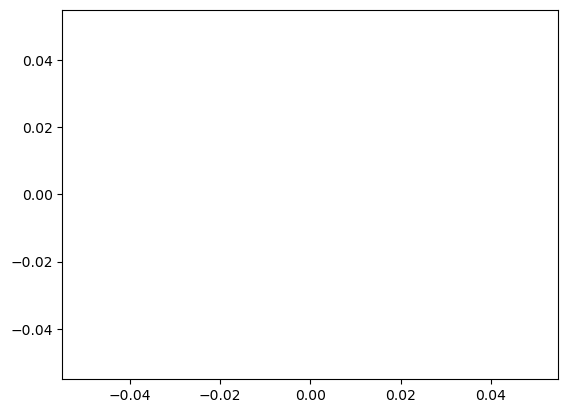

In [306]:
plt.figure()
plt.scatter(np.where(all_events[0])[0],np.where(all_events[0])[1])
plt.show()

In [309]:
np.sum(all_events), np.sum(all_input_events)

(0.0, 20.0)

In [331]:
inp_delays = np.random.randint(*delay_range, (inp_num, rec_num))
rec_delays = np.random.randint(*delay_range, (rec_num + inh_num, rec_num + inh_num))

all_input_events = np.zeros((combination_samples, T, inp_num))
all_rec_events = np.zeros((combination_samples, T, rec_num + inh_num))

inp_combs = np.random.randint(*delay_range, size=(combination_samples, inp_num))

for i, k in enumerate(inp_combs):
    all_input_events[i, k, np.arange(0, inp_num)] = 1

for l, inp_events in enumerate(tqdm(all_input_events)):
    rec_events = all_rec_events[l]
    for t in tqdm(range(start_time, end_time)):
        inp_indices = np.arange(inp_num)
        rec_indices = np.arange(rec_num)
        inh_indices = np.arange(rec_num, rec_num + inh_num)

        inp_contributions = np.sum(inp_events[t - inp_delays[:, rec_indices], inp_indices[:, None]], axis=0)
        rec_contributions = np.sum(rec_events[t - rec_delays[rec_indices, rec_indices[:, None]], rec_indices[:, None]], axis=1)
        inh_contributions = np.sum(rec_events[t - rec_delays[rec_and_inh_indices, inh_indices[:, None]], inh_indices[:, None]], axis=1)

        rec_events[t, rec_indices] = (inp_contributions >= 2).astype(int)
        rec_events[t, inh_indices] = np.where(inh_contributions > 1, -1, 0)

        if t >= start_time + max(delay_range) and np.sum(rec_events) == 0:
            break

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


ValueError: shape mismatch: value array of shape (20,) could not be broadcast to indexing result of shape (5500,)

In [340]:
7000 * 0.9**20

851.0365821339855

In [337]:
all_input_events

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0.,
         0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1.,
         1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0

In [333]:
np.sum(inp_events[t - inp_delays[:, rec_indices], inp_indices[:, None]], axis=0).shape

(5500,)

In [332]:
inp_events[t - inp_delays[:, rec_indices], inp_indices[:, None]].shape

(20, 5500)

In [330]:
np.sum(inp_events[t - inp_delays[:, rec_indices], inp_indices[:, None]], axis=1).shape
np.sum(rec_events[t - rec_delays[rec_indices, rec_indices[:, None]], rec_indices[:, None]], axis=1).shape

(5500,)

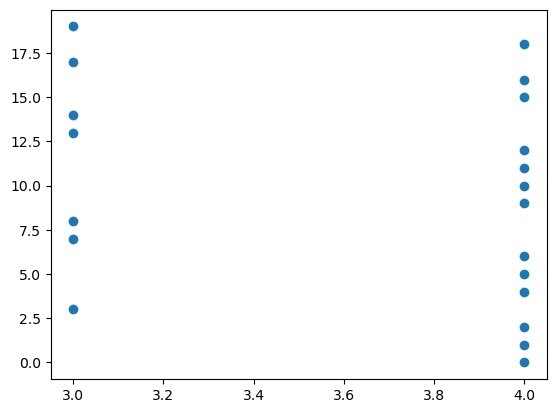

In [320]:
plt.figure()
plt.scatter(np.where(inp_events)[0],np.where(inp_events)[1])
plt.show()

In [323]:
inp_delays

array([[4, 4, 3, ..., 3, 4, 3],
       [4, 3, 3, ..., 3, 3, 4],
       [3, 3, 4, ..., 3, 4, 3],
       ...,
       [3, 4, 3, ..., 3, 4, 4],
       [3, 4, 3, ..., 3, 4, 3],
       [3, 3, 3, ..., 4, 4, 4]])